PyTorch Version: 2.7.0+cu126
Torchvision Version: 0.22.0+cu126
Original Image: /home/mramidi/final_assignment/view_of_delft/lidar/training/image_2/01647.jpg
Generated Segmentation Mask: /home/mramidi/final_assignment/generated_masks_for_finetuning/training/01647.png
Freezing backbone of DeepLabV3.
Modifying auxiliary classifier head.
Modified DeepLabV3 head for 4 classes. Backbone frozen: True
Model loaded from checkpoint and moved to: cpu
Loaded generated mask from: /home/mramidi/final_assignment/generated_masks_for_finetuning/training/01647.png
Input image tensor shape after preprocessing: torch.Size([1, 3, 520, 520])
Generated ground truth mask (PIL) size: (1936, 1216)
Resized generated ground truth mask shape: (520, 520)
Predicted mask shape: (520, 520)


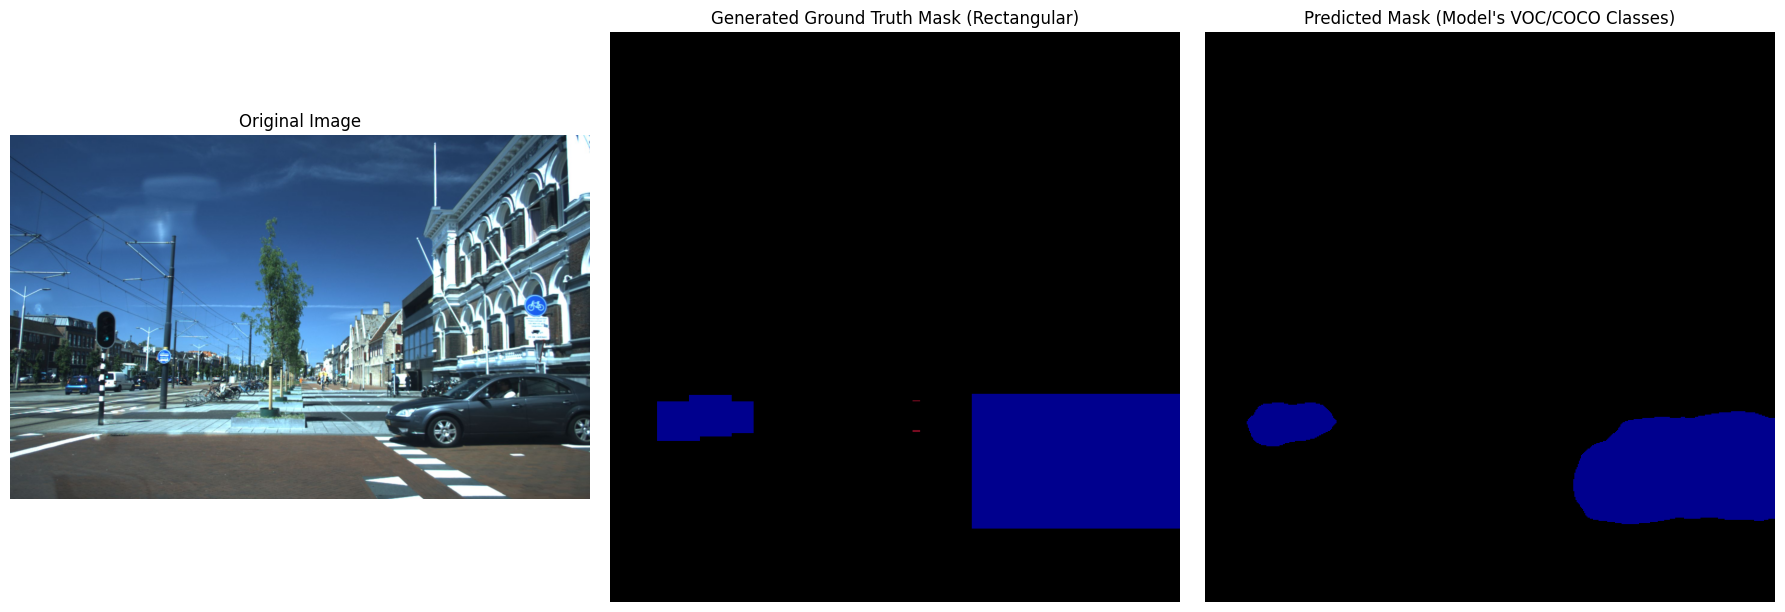


--- Inference Pipeline Execution Complete ---
This notebook used a mask pre-generated by 'generate_segmentation_masks.py'.

--- Key Takeaways for Fine-tuning ---
1. The 'Generated Ground Truth Mask' is a rectangular approximation.
2. The 'Predicted Mask' from the pre-trained model is still predicting VOC/COCO classes.
   You will see a mismatch because the model hasn't learned your specific 'Car', 'Pedestrian', 'Cyclist' classes from these masks yet.
3. The next crucial step is to fine-tune the model on your generated masks.


In [ ]:
# --- 1. Setup: Import necessary libraries ---
import os
import torch
import torchvision
import torchvision.transforms.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys

# Add the directory containing segmentation_model_lightning.py to sys.path
sys.path.append(os.path.abspath(os.getcwd()))
from segmentation_model_lightning import SegmentationLightningModel # Ensure this is the correct import path for your model

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

# --- 2. Define Dataset Paths and Target Frame ID ---
# Root directory of your View of Delft dataset
DATA_ROOT = "/home/mramidi/final_assignment/view_of_delft"
# Directory where the generated masks are stored (must match the script's OUTPUT_MASK_ROOT)
GENERATED_MASK_ROOT = "/home/mramidi/final_assignment/generated_masks_for_finetuning"

# --- Select a specific frame to visualize (e.g., the one you had in your .txt) ---
FRAME_ID = "01647" # Change this to any frame ID from your train.txt or val.txt
IMAGE_PATH = os.path.join(DATA_ROOT,"lidar", "training", "image_2", f"{FRAME_ID}.jpg") # Assuming training data
GENERATED_MASK_PATH = os.path.join(GENERATED_MASK_ROOT, "training", f"{FRAME_ID}.png") # Assuming training masks

print(f"Original Image: {IMAGE_PATH}")
print(f"Generated Segmentation Mask: {GENERATED_MASK_PATH}")

# --- 3. Define Finalized Target Class Mapping and Color Map for Visualization ---
# This MUST match the CLASS_MAPPING_FINETUNE used in your generate_segmentation_masks.py script.
CLASS_MAPPING_FINETUNE = {
    'Background': 0,
    'Car': 1,
    'Pedestrian': 2,
    'Cyclist': 3, # Keep 'bicycle' if that's what your KITTI labels say. Change to 'Cyclist' if relevant.
}
NUM_CLASSES_FINETUNE = len(CLASS_MAPPING_FINETUNE) # e.g., 4 classes (0,1,2,3)

# Define colors for your specific classes based on CLASS_MAPPING_FINETUNE
# Extend these colors if you add more classes
FINETUNE_LABEL_COLORS = np.zeros((NUM_CLASSES_FINETUNE, 3), dtype=np.uint8)
FINETUNE_LABEL_COLORS[CLASS_MAPPING_FINETUNE['Background']] = [0, 0, 0]         # Black
FINETUNE_LABEL_COLORS[CLASS_MAPPING_FINETUNE['Car']] = [0, 0, 142]              # Dark Blue
FINETUNE_LABEL_COLORS[CLASS_MAPPING_FINETUNE['Pedestrian']] = [220, 20, 60]     # Crimson
FINETUNE_LABEL_COLORS[CLASS_MAPPING_FINETUNE['Cyclist']] = [119, 11, 32]        # Brownish-red

# Function to decode segmentation mask (NumPy array of class IDs) to an RGB image
def decode_seg_map(image_mask_np, colors=FINETUNE_LABEL_COLORS):
    # Ensure mask values are within the range of defined colors
    valid_mask_np = np.clip(image_mask_np, 0, colors.shape[0] - 1)

    r = np.zeros_like(valid_mask_np).astype(np.uint8)
    g = np.zeros_like(valid_mask_np).astype(np.uint8)
    b = np.zeros_like(valid_mask_np).astype(np.uint8)

    for l in range(0, colors.shape[0]):
        idx = valid_mask_np == l
        r[idx] = colors[l, 0]
        g[idx] = colors[l, 1]
        b[idx] = colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

# --- 4. Load a pre-trained DeepLabV3 model ---
# This model is pre-trained on VOC/COCO and outputs 21 classes (0-20).
# For pure inference (without fine-tuning this notebook), it will still output 21 classes.
# When you fine-tune, you'll change the model's head to match NUM_CLASSES_FINETUNE.
VOC_COCO_NUM_CLASSES = 21 # The default output classes for torchvision DeepLabV3
VOC_COCO_WEIGHTS = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
#############################################################
# model = deeplabv3_resnet50(weights=VOC_COCO_WEIGHTS, progress=True)
# model.eval() # Set the model to evaluation mode

# # Check if CUDA is available and move model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# print(f"Model loaded and moved to: {device}")

try:
    # `map_location` ensures it loads fine whether you're on GPU or CPU
    model = SegmentationLightningModel.load_from_checkpoint(
        checkpoint_path='/home/mramidi/final_assignment/outputs/segmentation_output_dir/my_final_segmentation_try/checkpoints/ep38-my_final_segmentation_try.ckpt',
        num_classes=NUM_CLASSES_FINETUNE, # Must match num_classes used during training
        map_location=torch.device("cpu") # Load to CPU first, then move to GPU if available
    )
    model.eval() # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Model loaded from checkpoint and moved to: {device}")
except Exception as e:
    print(f"ERROR: Could not load model from checkpoint. Please check BEST_CHECKPOINT_PATH and SegmentationLightningModel definition. Details: {e}")
    # Exit or provide a dummy model if loading fails, to prevent further errors.
    # For now, we'll let it raise an error if critical.


# --- 5. Define Image Transformations ---
preprocess = Compose([
    Resize((520, 520)), # DeepLabV3 typically expects 520x520
    ToTensor(),
    Normalize(mean=VOC_COCO_WEIGHTS.transforms().mean, std=VOC_COCO_WEIGHTS.transforms().std),
])
# Transformations for the mask (should use Nearest Neighbor for resizing)
mask_transform = Compose([
    Resize((520, 520), interpolation=Image.NEAREST),
])


# --- 6. Load Original Image and Generated Mask ---
try:
    original_image = Image.open(IMAGE_PATH).convert("RGB")
    generated_ground_truth_mask_img = Image.open(GENERATED_MASK_PATH).convert("L") # 'L' mode for grayscale (class IDs)
    print(f"Loaded generated mask from: {GENERATED_MASK_PATH}")
except FileNotFoundError as e:
    print(f"ERROR: Could not load original image or generated mask. Ensure paths are correct and masks were pre-generated. Details: {e}")
    # Fallback to dummy data if files are not found, so the script can still run for demonstration.
    original_image = Image.new('RGB', (640, 480), color = (255, 0, 0))  # Red in RGB
    generated_ground_truth_mask_img = Image.new('L', (640, 480), color = int(CLASS_MAPPING_FINETUNE['Background']))  # Integer value for grayscale
    print("Using dummy image and mask as fallback.")


# Apply transformations to the image
input_tensor = preprocess(original_image)
input_batch = input_tensor.unsqueeze(0).to(device)

# Apply transformation to the generated mask
generated_ground_truth_mask_resized_np = np.array(mask_transform(generated_ground_truth_mask_img))

print(f"Input image tensor shape after preprocessing: {input_batch.shape}")
print(f"Generated ground truth mask (PIL) size: {generated_ground_truth_mask_img.size}")
print(f"Resized generated ground truth mask shape: {generated_ground_truth_mask_resized_np.shape}")

# --- 7. Perform Inference ---
with torch.no_grad(): # Disable gradient calculation for inference
    output = model(input_batch) # DeepLabV3 returns a dict, we need the 'out' key

# The output contains raw logits. Convert to probabilities and then to class predictions.
# The pre-trained model outputs probabilities for VOC/COCO's 21 classes.
probabilities = torch.softmax(output, dim=1)
predicted_mask = torch.argmax(probabilities, dim=1).squeeze(0) # Remove batch dim and get class indices

# Move the predicted mask back to CPU and convert to NumPy for visualization
predicted_mask_np = predicted_mask.cpu().numpy()
print(f"Predicted mask shape: {predicted_mask_np.shape}")

# --- 8. Visualize Results ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
# Decode the generated ground truth mask using your custom color map
segmented_gt = decode_seg_map(generated_ground_truth_mask_resized_np, colors=FINETUNE_LABEL_COLORS)
plt.imshow(segmented_gt)
plt.title("Generated Ground Truth Mask (Rectangular)")
plt.axis('off')

plt.subplot(1, 3, 3)
# Decode the predicted mask using your custom color map (this will map VOC/COCO IDs to your colors)
# IMPORTANT: The model still predicts VOC/COCO classes. The colors here are just a visualization.
# If your custom class IDs overlap with VOC/COCO IDs, the visualization might be misleading
# without re-mapping the predicted IDs to your custom class names.
segmented_prediction = decode_seg_map(predicted_mask_np, colors=FINETUNE_LABEL_COLORS)
plt.imshow(segmented_prediction)
plt.title("Predicted Mask (Model's VOC/COCO Classes)")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- Inference Pipeline Execution Complete ---")
print("This notebook used a mask pre-generated by 'generate_segmentation_masks.py'.")
print("\n--- Key Takeaways for Fine-tuning ---")
print("1. The 'Generated Ground Truth Mask' is a rectangular approximation.")
print("2. The 'Predicted Mask' from the pre-trained model is still predicting VOC/COCO classes.")
print("   You will see a mismatch because the model hasn't learned your specific 'Car', 'Pedestrian', 'Cyclist' classes from these masks yet.")
print("3. The next crucial step is to fine-tune the model on your generated masks.")